# Churn Analysis 

**Data Preparation Pipeline**

**This notebook cell defines the `ChurnDataLoader` class, which is a crucial first step in our churn prediction pipeline.**

**The primary responsibility of this class is to **load, prepare, and validate** all raw data sources required for feature engineering and modeling. It is designed to be reusable and to ensure data integrity from the start.**

**### Key Responsibilities:**

* **Load Data**: Loads all necessary CSV files:
    * `customer_history.csv`: Monthly transactional/activity data for all customers.
    * `customers.csv`: Static demographic data for all customers.
    * `reference_data.csv`: The training set, mapping `cust_id` to the target variable (`churn`).
    * `reference_data_test.csv`: The test set, containing `cust_id`s for submission.
* **Prepare Splits**: Creates clean `train` and `test` dataframes by:
    1.  Filtering the main `customer_history` and `customers` tables based on the IDs in the reference files.
    2.  Merging the `churn` target variable for the training set.
    3.  Converting date columns to the proper `datetime` format.
* **Data Quality Checks**: Automatically runs a series of validation checks (`_quality_checks`) on both train and test splits to ensure:
    * Customer IDs match between activity and reference data.
    * There are no unexpected `null` values.
    * Data shape and content are as expected.
* **Submission Utility**: Includes a `create_submission` method to format model predictions into the required CSV format.

**### Outputs:**

**This class prepares two sets of dataframes, ready for the `ChurnFeatureEngineer`:**

**1.  `df_train`: A dataframe of monthly activities for training customers.**

**2.  `ref_train`: A dataframe of demographic data and the `churn` label for training customers.**

**3.  `df_test`: A dataframe of monthly activities for test customers.**

**4.  `ref_test`: A dataframe of demographic data for test customers.**

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

class ChurnDataLoader:
    """
    Loads raw churn competition data (history, demographics, references)
    and prepares clean train/test splits ready for feature engineering.
    """
    
    def __init__(self):
        self.customer_history = None
        self.customers = None
        self.reference_data_train = None
        self.reference_data_test = None
        
        # Define required columns for activity data
        self.required_activity_cols = [
            'cust_id', 'date',
            'mobile_eft_all_cnt', 'mobile_eft_all_amt',
            'cc_transaction_all_cnt', 'cc_transaction_all_amt',
            'active_product_category_nbr'
        ]

    def load_data(self, 
                  customer_history_path='datasets/customer_history.csv',
                  customers_path='datasets/customers.csv',
                  reference_train_path='datasets/referance_data.csv',
                  reference_test_path='datasets/referance_data_test.csv'):
        """
        Loads all required CSV files into memory.
        """
        print("=" * 80)
        print("DATA LOADING STARTED")
        print("=" * 80)
        
        try:
            # 1. Customer history (monthly activities)
            print("\n1. Loading customer_history.csv...")
            self.customer_history = pd.read_csv(customer_history_path)
            print(f"   Shape: {self.customer_history.shape}")
            print(f"   Columns: {list(self.customer_history.columns)}")

            # 2. Customer demographics
            print("\n2. Loading customers.csv...")
            self.customers = pd.read_csv(customers_path)
            print(f"   Shape: {self.customers.shape}")
            print(f"   Columns: {list(self.customers.columns)}")

            # 3. Train reference data (with churn labels)
            print("\n3. Loading reference_data.csv (Train)...")
            self.reference_data_train = pd.read_csv(reference_train_path)
            print(f"   Shape: {self.reference_data_train.shape}")
            print(f"   Churn distribution:\n{self.reference_data_train['churn'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'}")

            # 4. Test reference data
            print("\n4. Loading reference_data_test.csv (Test)...")
            self.reference_data_test = pd.read_csv(reference_test_path)
            print(f"   Shape: {self.reference_data_test.shape}")
            print(f"   Columns: {list(self.reference_data_test.columns)}")

            print("\n✓ All files loaded successfully!\n")
        
        except FileNotFoundError as e:
            print(f"\n❌ FILE NOT FOUND ERROR: {e}")
            print("Please check your file paths.")
            raise
            
        return self
    
    def _prepare_data_split(self, reference_df, dataset_name):
        """
        Internal helper function to prepare a data split (Train or Test).
        """
        print("\n" + "=" * 80)
        print(f"PREPARING {dataset_name} DATA")
        print("=" * 80)

        if self.customer_history is None or self.customers is None:
            raise ValueError("Data not loaded. Please run .load_data() first.")

        # Get unique customer IDs for this split
        customer_ids = reference_df['cust_id'].unique()
        print(f"\n→ Found {len(customer_ids)} unique customers for {dataset_name}")

        # =========================================
        # 1. Prepare Activity Data (df_activity)
        # =========================================
        print(f"\n1. Filtering activity data (df_{dataset_name.lower()})...")
        df_activity = self.customer_history[
            self.customer_history['cust_id'].isin(customer_ids)
        ].copy()

        # Convert date column
        df_activity['date'] = pd.to_datetime(df_activity['date'])

        # Validate required columns
        missing_cols = [col for col in self.required_activity_cols if col not in df_activity.columns]
        if missing_cols:
            raise ValueError(f"❌ Missing required columns in customer_history: {missing_cols}")

        print(f"   ✓ Activity data prepared: {df_activity.shape}")
        print(f"   ✓ Date range: {df_activity['date'].min().date()} to {df_activity['date'].max().date()}")
        print(f"   ✓ Unique customers: {df_activity['cust_id'].nunique()}")

        # =========================================
        # 2. Prepare Reference Data (df_ref)
        # =========================================
        print(f"\n2. Filtering reference data (ref_{dataset_name.lower()})...")
        
        # Get demographic data
        df_ref = self.customers[
            self.customers['cust_id'].isin(customer_ids)
        ].copy()

        # For TRAIN data, merge the churn label
        if dataset_name == 'TRAIN':
            df_ref = df_ref.merge(
                reference_df[['cust_id', 'churn']],
                on='cust_id',
                how='left'
            )
            print(f"   ✓ Reference data prepared: {df_ref.shape}")
            print(f"   ✓ Churn distribution:")
            print(f"       - Active (0): {(df_ref['churn']==0).sum()} customers")
            print(f"       - Churned (1): {(df_ref['churn']==1).sum()} customers")
            print(f"       - Churn Rate: {df_ref['churn'].mean():.2%}")
        else:
            # For TEST data, just use demographics
            print(f"   ✓ Reference data prepared: {df_ref.shape}")
            print(f"   ✓ Note: 'churn' column not present in TEST data (as expected).")

        # Run final quality checks
        self._quality_checks(df_activity, df_ref, dataset_name)
        
        return df_activity, df_ref

    def prepare_train_data(self):
        """
        Prepares the training data (df_train, ref_train).
        """
        return self._prepare_data_split(self.reference_data_train, 'TRAIN')

    def prepare_test_data(self):
        """
        Prepares the test data (df_test, ref_test).
        """
        return self._prepare_data_split(self.reference_data_test, 'TEST')

    def _quality_checks(self, df_activity, df_ref, dataset_name):
        """
        Internal: Runs data quality checks on the prepared data.
        """
        print(f"\n{'-'*80}")
        print(f"DATA QUALITY CHECK - {dataset_name}")
        print(f"{'-'*80}")
        
        # 1. Customer ID Matching
        print("\n1. Customer ID Matching:")
        activity_customers = set(df_activity['cust_id'].unique())
        ref_customers = set(df_ref['cust_id'].unique())
        
        missing_in_ref = activity_customers - ref_customers
        missing_in_activity = ref_customers - activity_customers
        
        if missing_in_ref:
            print(f"   ⚠ {len(missing_in_ref)} customers in activity data are missing from reference data.")
        if missing_in_activity:
            print(f"   ⚠ {len(missing_in_activity)} customers in reference data are missing from activity data.")
        
        if not missing_in_ref and not missing_in_activity:
            print(f"   ✓ Customer ID Match: All customers present in both datasets.")
        
        # 2. Null Value Check
        print(f"\n2. Null Value Check:")
        null_counts_activity = df_activity.isnull().sum()
        if null_counts_activity.sum() > 0:
            print(f"   df_activity nulls:\n{null_counts_activity[null_counts_activity > 0]}")
        else:
            print(f"   ✓ No null values in activity data.")
        
        null_counts_ref = df_ref.isnull().sum()
        if null_counts_ref.sum() > 0:
            print(f"   df_ref nulls:\n{null_counts_ref[null_counts_ref > 0]}")
        else:
            print(f"   ✓ No null values in reference data.")
            
        # 3. Months per Customer Stats
        months_per_customer = df_activity.groupby('cust_id').size()
        print(f"\n3. Months per Customer Stats:")
        print(f"   Min: {months_per_customer.min()} months")
        print(f"   Max: {months_per_customer.max()} months")
        print(f"   Mean: {months_per_customer.mean():.1f} months")
        print(f"   Median: {months_per_customer.median():.1f} months")

    def create_submission(self, predictions, output_path='submission.csv'):
        """
        Creates a submission file in the required format.
        
        Args:
            predictions: A list or array of churn probabilities (0-1)
            output_path: The path to save the output CSV file
        """
        if self.reference_data_test is None:
            raise ValueError("Test reference data not loaded. Run .load_data() first.")
            
        submission = pd.DataFrame({
            'cust_id': self.reference_data_test['cust_id'],
            'churn': predictions
        })
        
        submission.to_csv(output_path, index=False)
        print(f"\n✓ Submission file created: {output_path}")
        print(f"   Shape: {submission.shape}")
        print(f"   Sample predictions:\n{submission.head()}")
        
        return submission

# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("""
    ╔════════════════════════════════════════════════════════════════════════════╗
    ║                     CHURN PREDICTION - DATA LOADER                       ║
    ╚════════════════════════════════════════════════════════════════════════════╝
    """)
    
    # 1. Initialize the loader
    loader = ChurnDataLoader()
    
    # 2. Load all files
    # (Using a try-except block for robustness in a real script)
    try:
        loader.load_data(
            customer_history_path='datasets/customer_history.csv',
            customers_path='datasets/customers.csv',
            reference_train_path='datasets/referance_data.csv',
            reference_test_path='datasets/referance_data_test.csv'
        )
        
        # 3. Prepare Train data
        df_train, ref_train = loader.prepare_train_data()
        
        # 4. Prepare Test data
        df_test, ref_test = loader.prepare_test_data()
        
        print("\n" + "="*80)
        print("DATA PREPARATION COMPLETE!")
        print("="*80)
        print(f"\n📊 Train Datasets:")
        print(f"   • df_train: {df_train.shape} - Monthly activity data")
        print(f"   • ref_train: {ref_train.shape} - Demographics + churn label")
        print(f"\n📊 Test Datasets:")
        print(f"   • df_test: {df_test.shape} - Monthly activity data")
        print(f"   • ref_test: {ref_test.shape} - Demographics only")

    except FileNotFoundError:
        print("\nSTOPPING EXECUTION due to missing files.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")


    ╔════════════════════════════════════════════════════════════════════════════╗
    ║                     CHURN PREDICTION - DATA LOADER                       ║
    ╚════════════════════════════════════════════════════════════════════════════╝
    
DATA LOADING STARTED

1. Loading customer_history.csv...
   Shape: (5359609, 7)
   Columns: ['cust_id', 'date', 'mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 'cc_transaction_all_amt', 'cc_transaction_all_cnt']

2. Loading customers.csv...
   Shape: (176293, 8)
   Columns: ['cust_id', 'gender', 'age', 'province', 'religion', 'work_type', 'work_sector', 'tenure']

3. Loading reference_data.csv (Train)...
   Shape: (133287, 3)
   Churn distribution:
churn
0    85.84%
1    14.16%
Name: proportion, dtype: object

4. Loading reference_data_test.csv (Test)...
   Shape: (43006, 2)
   Columns: ['cust_id', 'ref_date']

✓ All files loaded successfully!


PREPARING TRAIN DATA

→ Found 133287 unique customers for TRAIN

1

**Data Discovery**

customer_history.csv → global transaction history (176k users).

customer.csv → all digital demographics (176k users).

reference_data.csv → training customers with churn tags (133k users).

reference_data_test.csv → test customers to estimate churn (43k users).

EDA ANALYSIS

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

churn
0    0.858426
1    0.141574
Name: proportion, dtype: float64


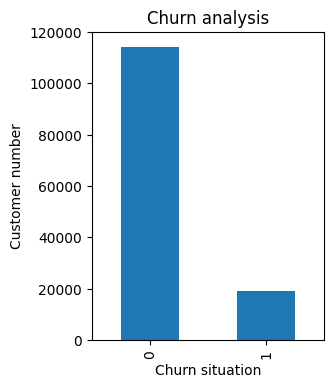

In [5]:
print(ref_train["churn"].value_counts(normalize=True))

plt.figure(figsize=(3,4))
ref_train["churn"].value_counts().plot(kind="bar")
plt.title("Churn analysis")
plt.xlabel('Churn situation')
plt.ylabel('Customer number')
plt.show()

***Number of Monthly Transactions per Customer***

count    133287.000000
mean         27.466107
std           5.195994
min          19.000000
25%          23.000000
50%          27.000000
75%          32.000000
max          36.000000
Name: date, dtype: float64


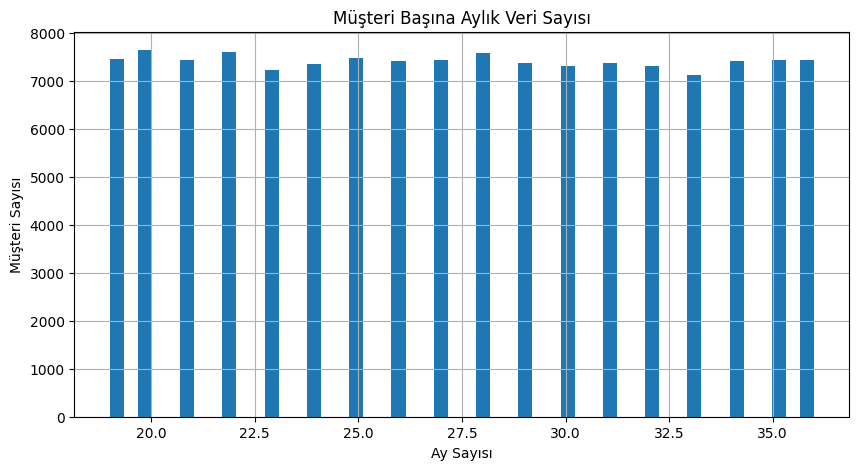

KeyError: "Column(s) ['churn'] do not exist"

In [6]:
# Her müşterinin kaç aylık verisi var?
months_per_customer = df_train.groupby('cust_id')['date'].nunique()
print(months_per_customer.describe())

# Dağılım grafiği
plt.figure(figsize=(10, 5))
months_per_customer.hist(bins=50)
plt.title('Müşteri Başına Aylık Veri Sayısı')
plt.xlabel('Ay Sayısı')
plt.ylabel('Müşteri Sayısı')
plt.show()

# Churn'a göre ay sayısı karşılaştırması
months_with_churn = df_train.groupby('cust_id').agg({
    'date': 'nunique',
    'churn': 'first'
}).reset_index()
months_with_churn.columns = ['cust_id', 'month_count', 'churn']

plt.figure(figsize=(10, 5))
sns.boxplot(data=months_with_churn, x='churn', y='month_count')
plt.title('Churn Durumuna Göre Veri Süresi')
plt.show()

***Categorical Variable Distributions***

IndexError: index 6 is out of bounds for axis 0 with size 6

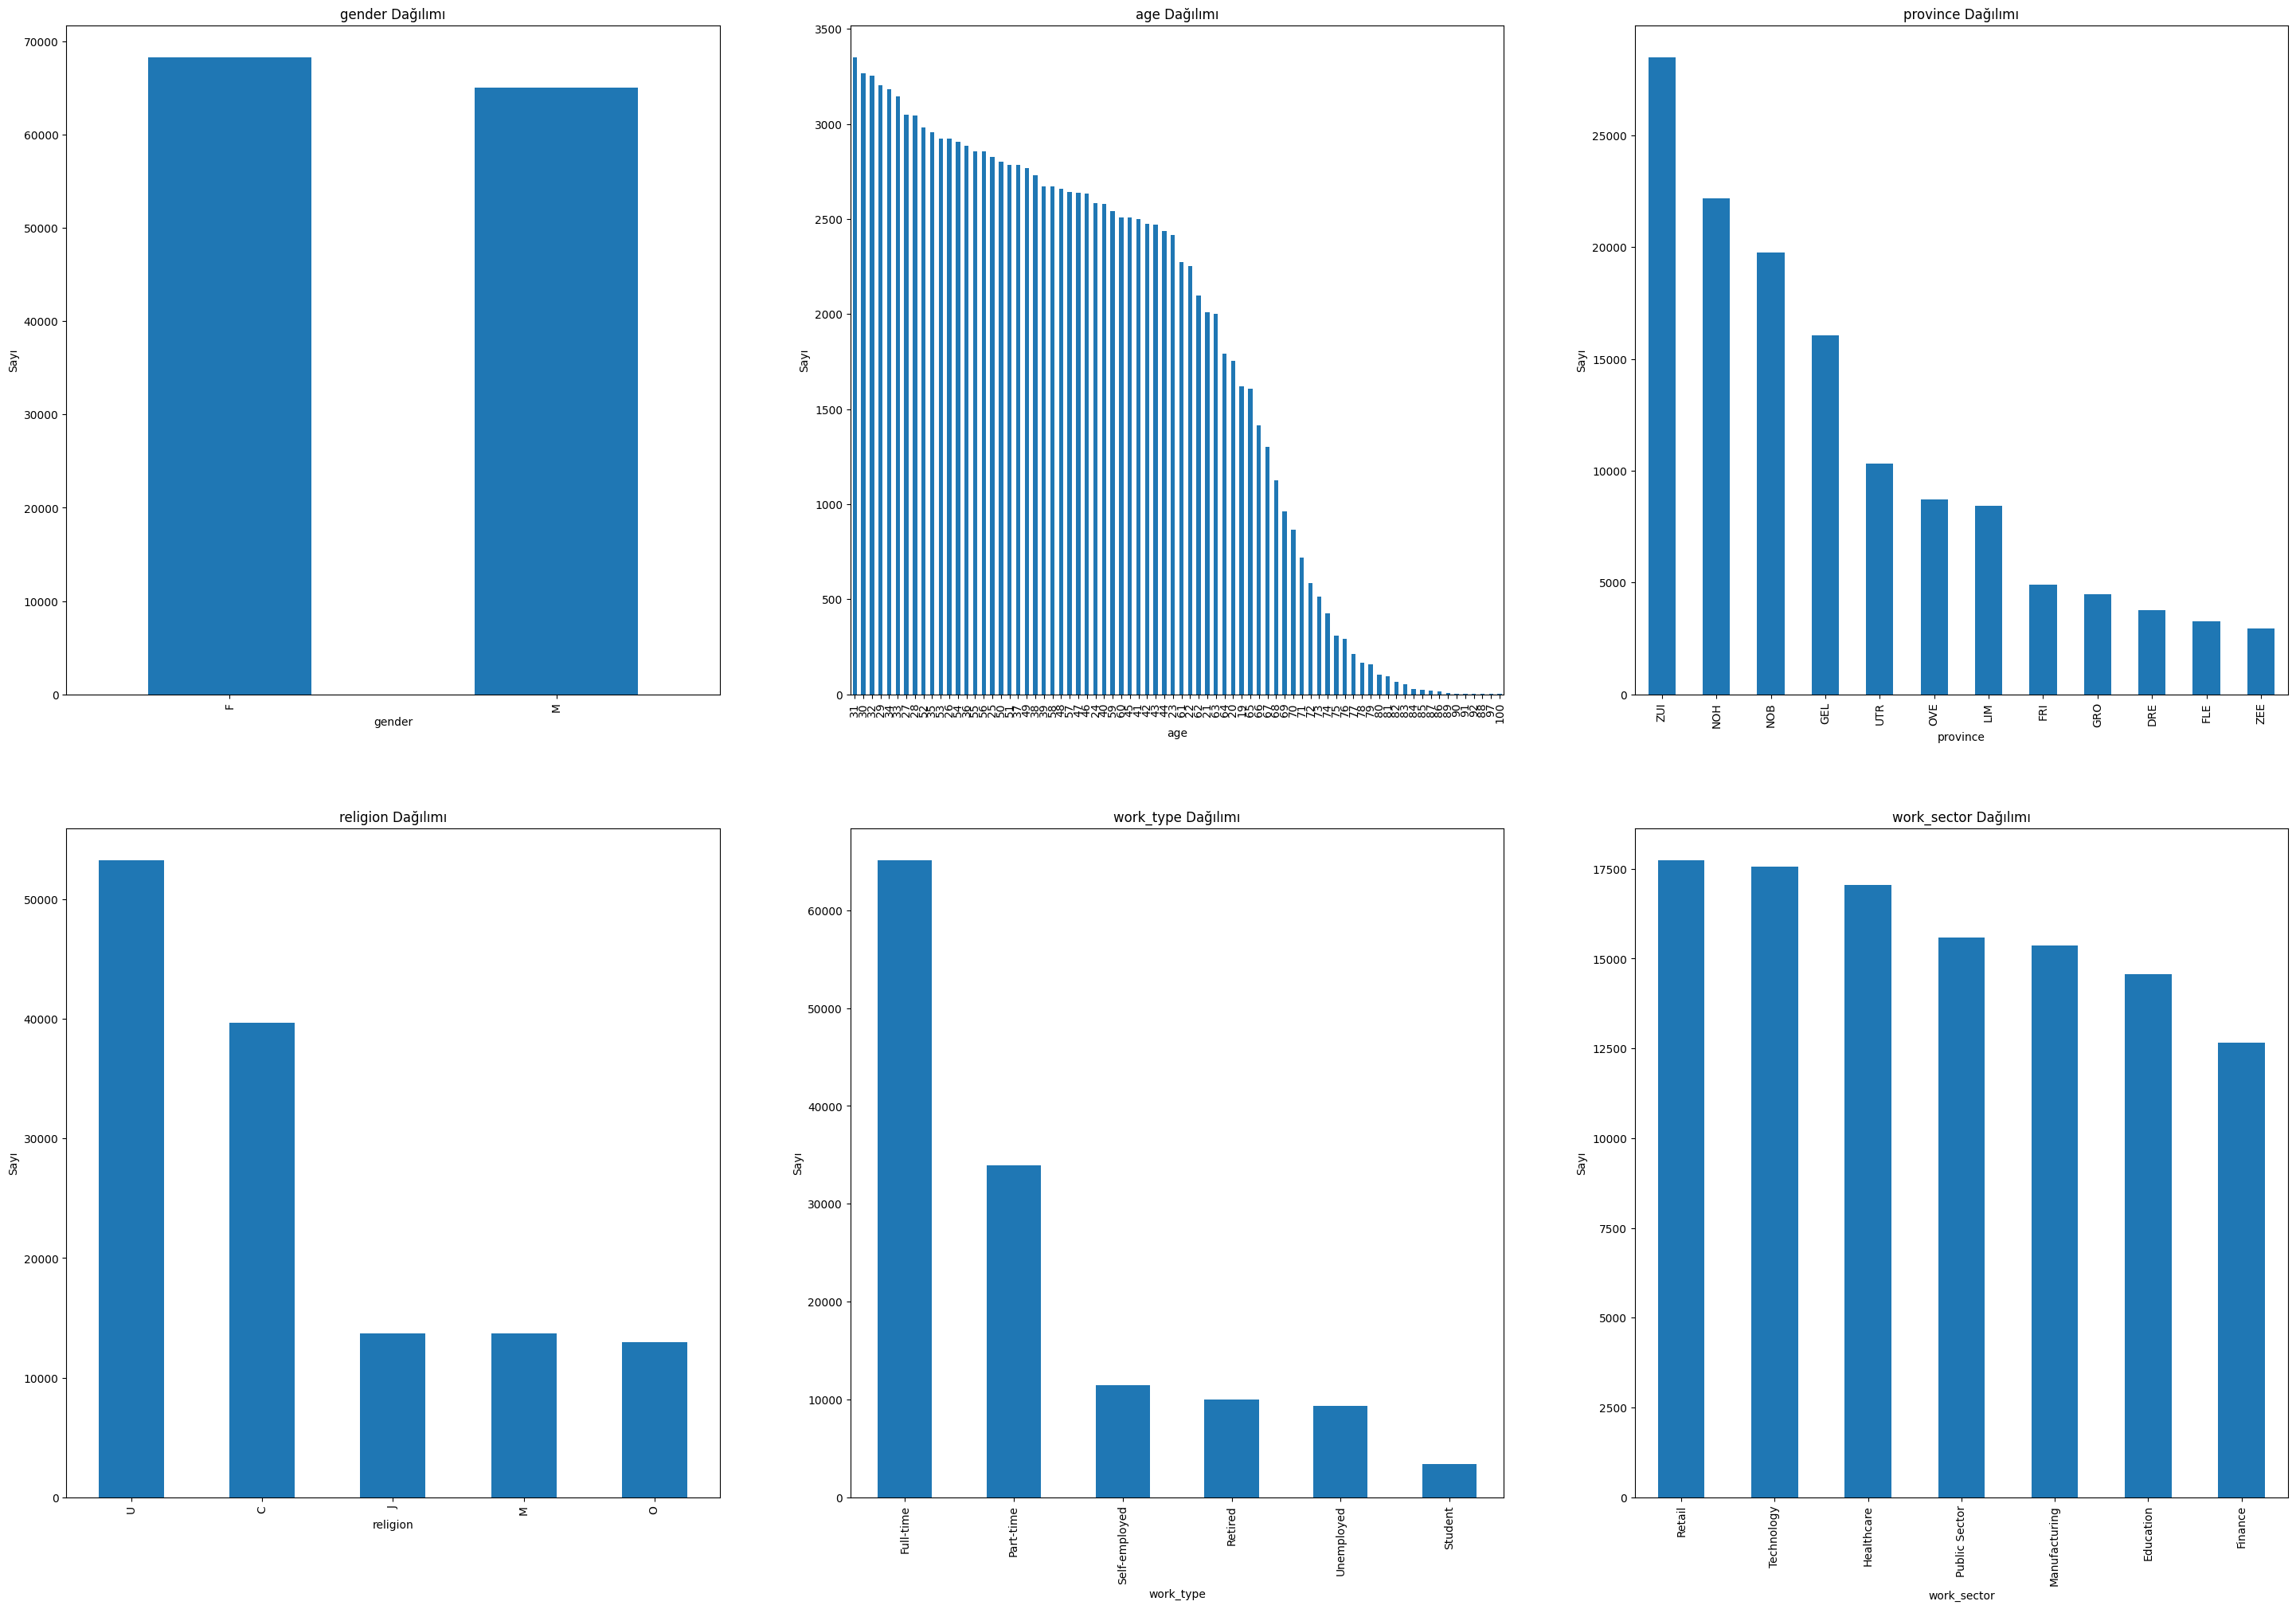

In [14]:
categorical_columns = ['gender','age','province','religion','work_type','work_sector','tenure']
fig, axes = plt.subplots(2, 3, figsize=(36, 24))
axes = axes.flatten()
for i, col in enumerate(categorical_columns):
    if col in ref_train.columns:
        ref_train[col].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'{col} Dağılımı')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Sayı')

plt.tight_layout()
plt.show()

 MÜŞTERİ BAZINDA ÖZET İSTATİSTİKLER


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ========================================
# 0. SETUP: FIX DATA (Merge Churn and Define Ref Date)
# ========================================
# Merge churn labels from ref_train into df_train
print("Merging churn labels...")
churn_labels = ref_train[['cust_id', 'churn']]
df_train_merged = pd.merge(df_train, churn_labels, on='cust_id', how='left')

# Define the reference date (e.g., 1 day after the last transaction)
ref_date = df_train_merged['date'].max() + pd.Timedelta(days=1)
print(f"Reference date set to: {ref_date.date()}")
print("--- Setup Complete --- \n")


# ========================================
# 1. CUSTOMER-LEVEL SUMMARY STATISTICS
# ========================================
# Summary for each customer over the entire period
customer_summary = df_train_merged.groupby('cust_id').agg({
    # Mobile EFT
    'mobile_eft_all_cnt': ['sum', 'mean', 'std', 'max'],
    'mobile_eft_all_amt': ['sum', 'mean', 'std', 'max'],
    # Credit Card
    'cc_transaction_all_cnt': ['sum', 'mean', 'std', 'max'],
    'cc_transaction_all_amt': ['sum', 'mean', 'std', 'max'],
    # Active product
    'active_product_category_nbr': ['mean', 'std', 'max'],
    # Churn
    'churn': 'first',
    # Number of months
    'date': 'count'
}).reset_index()

# Fix multi-index column names
customer_summary.columns = ['_'.join(col).strip('_') for col in customer_summary.columns]
customer_summary.rename(columns={'cust_id_': 'cust_id', 'churn_first': 'churn', 
                                 'date_count': 'num_months'}, inplace=True)

# Count months with zero transactions
zero_mobile_eft = df_train_merged[df_train_merged['mobile_eft_all_cnt'] == 0].groupby('cust_id').size()
zero_cc = df_train_merged[df_train_merged['cc_transaction_all_cnt'] == 0].groupby('cust_id').size()

customer_summary['zero_mobile_eft_months'] = customer_summary['cust_id'].map(zero_mobile_eft).fillna(0)
customer_summary['zero_cc_months'] = customer_summary['cust_id'].map(zero_cc).fillna(0)

# Total transactions
customer_summary['total_transactions_sum'] = (customer_summary['mobile_eft_all_cnt_sum'] + 
                                              customer_summary['cc_transaction_all_cnt_sum'])
customer_summary['total_amount_sum'] = (customer_summary['mobile_eft_all_amt_sum'] + 
                                        customer_summary['cc_transaction_all_amt_sum'])

# Average transactions per month
customer_summary['avg_transactions_per_month'] = (customer_summary['total_transactions_sum'] / 
                                                  customer_summary['num_months'])
customer_summary['avg_amount_per_month'] = (customer_summary['total_amount_sum'] / 
                                            customer_summary['num_months'])

print("Customer summary statistics created.")
print(f"Total customers: {len(customer_summary)}")

# ========================================
# 2. COMPARISON BY CHURN
# ========================================
print("\n--- TRANSACTION STATISTICS BY CHURN STATUS ---")

comparison_features = [
    'mobile_eft_all_cnt_sum', 'mobile_eft_all_cnt_mean',
    'mobile_eft_all_amt_sum', 'mobile_eft_all_amt_mean',
    'cc_transaction_all_cnt_sum', 'cc_transaction_all_cnt_mean',
    'cc_transaction_all_amt_sum', 'cc_transaction_all_amt_mean',
    'total_transactions_sum', 'total_amount_sum',
    'avg_transactions_per_month', 'avg_amount_per_month',
    'zero_mobile_eft_months', 'zero_cc_months',
    'active_product_category_nbr_mean'
]

comparison_df = customer_summary.groupby('churn')[comparison_features].mean()
comparison_df['customer_count'] = customer_summary.groupby('churn').size()

print(comparison_df.T)

# Calculate percentage difference
print("\n--- PERCENTAGE DIFFERENCE (CHURN=1 vs CHURN=0) ---")

for feature in comparison_features:
    churn_0 = comparison_df.loc[0.0, feature]
    churn_1 = comparison_df.loc[1.0, feature]
    pct_diff = ((churn_1 - churn_0) / churn_0) * 100 if churn_0 != 0 else 0
    print(f"{feature:40s}: {pct_diff:+.2f}%")

# ========================================
# 3. VISUALIZATION - BOX PLOTS
# ========================================

# Select features for visualization (requires log scale)
log_features = [
    ('mobile_eft_all_cnt_sum', 'Total Mobile EFT Count'),
    ('mobile_eft_all_amt_sum', 'Total Mobile EFT Amount (€)'),
    ('cc_transaction_all_cnt_sum', 'Total Credit Card Transaction Count'),
    ('cc_transaction_all_amt_sum', 'Total Credit Card Transaction Amount (€)'),
    ('total_transactions_sum', 'Total Transaction Count'),
    ('total_amount_sum', 'Total Transaction Amount (€)'),
    ('avg_transactions_per_month', 'Avg Transactions Per Month'),
    ('zero_mobile_eft_months', 'Months with Zero Mobile EFT'),
    ('zero_cc_months', 'Months with Zero Credit Card'),
]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, (feature, title) in enumerate(log_features):
    # Replace 0 with 0.1 for log scale
    plot_data = customer_summary[['churn', feature]].copy()
    plot_data[feature] = plot_data[feature].replace(0, 0.1)
    
    sns.boxplot(data=plot_data, x='churn', y=feature, ax=axes[i])
    axes[i].set_yscale('log')
    axes[i].set_title(title, fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Churn (0=Active, 1=Churned)')
    axes[i].set_ylabel('Value (log scale)')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('churn_transaction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 4. TEMPORAL ANALYSIS (LAST MONTHS vs. PREVIOUS)
# ========================================
print("\n--- TEMPORAL ANALYSIS (LAST 3 MONTHS vs. PREVIOUS) ---")

# Calculate months from reference date
df_train_merged['months_to_ref'] = ((ref_date - df_train_merged['date']).dt.days / 30).round().astype(int)

# Last 3 months
last_3_months = df_train_merged[df_train_merged['months_to_ref'] <= 3].groupby('cust_id').agg({
    'mobile_eft_all_cnt': 'sum',
    'mobile_eft_all_amt': 'sum',
    'cc_transaction_all_cnt': 'sum',
    'cc_transaction_all_amt': 'sum',
    'churn': 'first'
}).reset_index()
last_3_months.columns = ['cust_id', 'last3_mobile_cnt', 'last3_mobile_amt', 
                         'last3_cc_cnt', 'last3_cc_amt', 'churn']

# Previous period (4-12 months)
previous_period = df_train_merged[(df_train_merged['months_to_ref'] > 3) & (df_train_merged['months_to_ref'] <= 12)].groupby('cust_id').agg({
    'mobile_eft_all_cnt': 'mean',
    'mobile_eft_all_amt': 'mean',
    'cc_transaction_all_cnt': 'mean',
    'cc_transaction_all_amt': 'mean'
}).reset_index()
previous_period.columns = ['cust_id', 'prev_mobile_cnt', 'prev_mobile_amt', 
                           'prev_cc_cnt', 'prev_cc_amt']

# Merge temporal data
temporal_analysis = last_3_months.merge(previous_period, on='cust_id', how='inner')

# Calculate change
temporal_analysis['mobile_cnt_change'] = (temporal_analysis['last3_mobile_cnt'] / 3 - 
                                          temporal_analysis['prev_mobile_cnt'])
temporal_analysis['cc_cnt_change'] = (temporal_analysis['last3_cc_cnt'] / 3 - 
                                      temporal_analysis['prev_cc_cnt'])

print("\nAverage Transactions (Last 3 Months):")
print(temporal_analysis.groupby('churn')[['last3_mobile_cnt', 'last3_cc_cnt']].mean() / 3)

print("\nAverage Transactions (Previous Period 4-12 Mo):")
print(temporal_analysis.groupby('churn')[['prev_mobile_cnt', 'prev_cc_cnt']].mean())

print("\nMonthly Change (Last 3 Mo Avg - Prev Avg):")
print(temporal_analysis.groupby('churn')[['mobile_cnt_change', 'cc_cnt_change']].mean())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mobile EFT change
sns.boxplot(data=temporal_analysis, x='churn', y='mobile_cnt_change', ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[0].set_title('Mobile EFT Transaction Change\n(Last 3 Mo Avg - Prev Period Avg)', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Churn (0=Active, 1=Churned)')
axes[0].set_ylabel('Monthly Transaction Change')
axes[0].grid(True, alpha=0.3, axis='y')

# Credit Card change
sns.boxplot(data=temporal_analysis, x='churn', y='cc_cnt_change', ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1].set_title('Credit Card Transaction Change\n(Last 3 Mo Avg - Prev Period Avg)', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Churn (0=Active, 1=Churned)')
axes[1].set_ylabel('Monthly Transaction Change')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('churn_temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# 5. STATISTICAL TESTS
# ========================================
print("\n--- STATISTICAL TESTS (Mann-Whitney U Test) ---")

test_features = [
    ('total_transactions_sum', 'Total Transaction Count'),
    ('total_amount_sum', 'Total Transaction Amount'),
    ('avg_transactions_per_month', 'Avg Monthly Transactions'),
    ('zero_mobile_eft_months', 'Months w/ Zero Mobile EFT'),
    ('zero_cc_months', 'Months w/ Zero Credit Card'),
]

for feature, name in test_features:
    churn_0 = customer_summary[customer_summary['churn'] == 0.0][feature]
    churn_1 = customer_summary[customer_summary['churn'] == 1.0][feature]
    
    # Check for empty groups before testing
    if not churn_0.empty and not churn_1.empty:
        statistic, p_value = stats.mannwhitneyu(churn_0, churn_1, alternative='two-sided')
        
        print(f"\n{name}:")
        print(f"  p-value: {p_value:.2e}")
        print(f"  Significant difference: {'YES' if p_value < 0.05 else 'NO'}")
        print(f"  Median (Churn=0): {churn_0.median():.2f}")
        print(f"  Median (Churn=1): {churn_1.median():.2f}")
    else:
        print(f"\nSkipping test for {name} (one group is empty).")

print("\n--- ANALYSIS COMPLETE ---")

***ANALYSIS RESULTS***

**Time-Based Customer Behavior Analysis**

The analysis of customer summary statistics reveals significant differences in customer behavior based on churn status in terms of transaction volume, transaction frequency, and product variety. In a dataset of 133,287 customers, non-churn customers exhibit a more active profile in both mobile EFT and credit card transactions. Specifically, the total number of transactions and transaction amount are approximately 10% and 13% higher in the non-churn group, respectively. This demonstrates that financial interaction is directly proportional to customer loyalty.

The average monthly number of transactions and transaction amounts follow a similar trend; non-churn customers make an average of 22.55 transactions and approximately 1021 TL per month, while churn customers make 20.71 transactions and 900 TL per month, respectively. Conversely, the "number of zero mobile EFT months" increased by 8.6% in the churn group, suggesting that users at risk of churn become completely inactive during certain periods. Additionally, the average number of active product categories for customers in the churn group is approximately 10% lower, indicating that users with less product variety are more likely to churn.

Time-based analyses also support these findings. While relative stability was observed in the number of mobile and credit card transactions for customers who did not churn over the past three months, there was a significant decrease in the number of mobile and credit card transactions in the churn group (−0.10 for mobile, −0.02 for credit card). This suggests that customer transaction frequency decreased prior to the churn, indicating that the churn provides a behavioral precursor. Therefore, these results suggest that indicators such as a decrease in transaction volume, a decrease in product variety, and periodic inactivity can be used as early warning signals in churn prediction.

**Mann-Whitney U Test Confirms Differences in Metrics**

Significant behavioral differences exist between the churn and non-churn groups. The analysis examined key customer activity indicators such as total transaction count, total transaction amount, average monthly transactions, and the number of months without mobile EFT. The results showed that p-values ​​for all variables were well below 0.05, indicating that the differences were not random and were statistically significant. The findings indicate that non-churn customers not only make more transactions but also have higher transaction volumes. Furthermore, these customers conduct more regular transactions monthly and have fewer months without trading. This suggests that high transaction frequency and volume are directly related to customer loyalty, while a tendency to remain inactive increases the risk of churn. Therefore, while financially active users who maintain customer interaction are more likely to be retained, passive users constitute a critical risk group for churn.

# Churn Prediction: Feature Engineering Pipeline

This notebook defines the `ChurnFeatureEngineer`, a comprehensive, scikit-learn-compatible transformer class that converts raw transactional data and static customer data into a feature matrix ready for machine learning.

## Key Responsibilities

**`fit_transform(df_train, ref_train)`**
- Learns parameters from training data
- Learns MinMaxScaler for RFM scores  
- Learns LabelEncoder for categorical features
- Learns global mean values for imputation
- Transforms training data into `X_train`

**`transform(df_test, ref_test)`**
- Applies learned parameters to test data
- Prevents data leakage
- Transforms test data into `X_test`

## Generated Feature Groups

**Aggregate Statistics**  
Overall customer behavior (sum, mean, std, max) for transactions and amounts

**Temporal Window Features**  
Customer activity in recent time windows (Last 1M, 3M, 6M)

**Inactivity & Recency (RFM)**  
- `zero_mobile_months`, `zero_cc_months`, `months_since_last_transaction`  
- RFM scores and `rfm_total_score`

**Trend & Volatility Features**  
- `mobile_cnt_trend`, `cc_volatility`, `decline_acceleration`

**Composite Risk Scores**  
- `inactivity_risk_score`, `weighted_inactivity`, `temporal_churn_risk`

**Behavioral & Interaction Features**  
- `transaction_type_diversity`, `product_usage_stability`, `age_transaction_intensity`

**Categorical Encoding**  
Transforms demographic columns using LabelEncoder

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from typing import List, Dict, Any

class ChurnFeatureEngineer:
    """
    Transforms raw customer activity data (df) and demographic data (ref_customer_data)
    into a wide feature matrix for churn modeling.

    Follows a scikit-learn style .fit_transform() / .transform() paradigm to
    prevent data leakage.
    """
    
    def __init__(self):
        # Fitted parameters
        self.reference_date_: pd.Timestamp = None
        self.rfm_scaler_: MinMaxScaler = None
        self.encoders_: Dict[str, LabelEncoder] = {}
        self.imputation_values_: Dict[str, float] = {}
        self.fitted_: bool = False

        # Configuration
        self.categorical_cols_: List[str] = [
            'gender', 'province', 'work_type', 'work_sector', 'religion'
        ]
        
        self.imputation_map_: Dict[str, str] = {
            'prev_mobile_cnt': 'mobile_eft_all_cnt_mean',
            'prev_mobile_amt': 'mobile_eft_all_amt_mean',
            'prev_cc_cnt': 'cc_transaction_all_cnt_mean',
            'prev_cc_amt': 'cc_transaction_all_amt_mean',
            'prev_products': 'active_product_category_nbr_mean',
        }
        
        self.prev_cols_: List[str] = list(self.imputation_map_.keys())
        
        self.prev_std_max_cols_: List[str] = [
            'prev_mobile_cnt_std', 'prev_mobile_cnt_max',
            'prev_mobile_amt_std', 'prev_mobile_amt_max',
            'prev_cc_cnt_std', 'prev_cc_cnt_max',
            'prev_cc_amt_std', 'prev_cc_amt_max',
            'prev_products_std'  # 'prev_products_max' buradan kaldırıldı
        ]
        self.last1_cols_: List[str] = [
            'last1_mobile_cnt', 'last1_mobile_amt', 
            'last1_cc_cnt', 'last1_cc_amt', 'last1_products'
        ]

    def fit_transform(self, df: pd.DataFrame, ref_customer_data: pd.DataFrame) -> pd.DataFrame:
        """
        Learns transformation parameters from the training data and returns
        the transformed training feature matrix.
        
        Args:
            df: DataFrame with time-series activity data (e.g., df_train).
            ref_customer_data: DataFrame with static demographic data (e.g., ref_train).

        Returns:
            pd.DataFrame: The final training feature matrix, X_train.
        """
        print("\n" + "="*80)
        print("Mode: 'train' -> Running .fit_transform()...")
        print("="*80)

        df_proc = df.copy()
        ref_data = self._ensure_cust_id(ref_customer_data)

        # Learn parameters
        self.reference_date_ = df_proc['date'].max()
        print(f"--> Reference date learned: {self.reference_date_.date()}")

        # Learn imputation values
        total_activity_for_imputation = self._calculate_total_activity(df_proc)
        for key, value in self.imputation_map_.items():
            self.imputation_values_[key] = total_activity_for_imputation[value].mean()
        print("--> Imputation values for 'previous period' learned.")

        # Initialize scalers and encoders
        self.rfm_scaler_ = MinMaxScaler()
        self.encoders_ = {col: LabelEncoder() for col in self.categorical_cols_}
        print("--> Scalers and Encoders initialized.")

        # Transform data
        features = self._create_feature_matrix(df_proc, ref_data, mode='train')
        
        self.fitted_ = True
        print("\n--> Fit complete. Training data transformed.")
        return features

    def transform(self, df: pd.DataFrame, ref_customer_data: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms new data (e.g., test data) using the parameters
        learned during the .fit_transform() call.

        Args:
            df: DataFrame with time-series activity data (e.g., df_test).
            ref_customer_data: DataFrame with static demographic data (e.g., ref_test).

        Returns:
            pd.DataFrame: The final test feature matrix, X_test.
        """
        print("\n" + "="*80)
        print("Mode: 'test' -> Running .transform()...")
        print("="*80)
        
        if not self.fitted_:
            raise RuntimeError("Must call .fit_transform() on training data first.")
        
        df_proc = df.copy()
        ref_data = self._ensure_cust_id(ref_customer_data)
        
        features = self._create_feature_matrix(df_proc, ref_data, mode='test')
        
        print("\n--> Test data transformed.")
        return features

    def _ensure_cust_id(self, ref_data: pd.DataFrame) -> pd.DataFrame:
        """Checks for 'cust_id' and creates it from the index if missing."""
        ref_data = ref_data.copy()
        if 'cust_id' not in ref_data.columns:
            print("--> 'cust_id' not found in ref_data, creating from index...")
            ref_data = ref_data.reset_index().rename(columns={'index': 'cust_id'})
        return ref_data

    def _calculate_total_activity(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculates aggregate features for the entire customer history."""
        agg_df = df.groupby('cust_id').agg({
            'mobile_eft_all_cnt': ['sum', 'mean', 'std', 'max'],
            'mobile_eft_all_amt': ['sum', 'mean', 'std', 'max'],
            'cc_transaction_all_cnt': ['sum', 'mean', 'std', 'max'],
            'cc_transaction_all_amt': ['sum', 'mean', 'std', 'max'],
            'active_product_category_nbr': ['mean', 'std'],
            'date': 'count'
        }).reset_index()
        
        agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns]
        agg_df.rename(columns={'cust_id_': 'cust_id', 'date_count': 'num_months'}, inplace=True)
        return agg_df
        
    def _create_feature_matrix(self, df: pd.DataFrame, ref_customer_data: pd.DataFrame, mode: str) -> pd.DataFrame:
        """
        Master function to build all features.
        This function is now a pipeline that calls smaller helper methods.
        """
        # 0. Base features
        features = ref_customer_data.copy()
        
        # 1. Temporal Windows
        print("1. Building temporal window features...")
        df['months_from_end'] = ((self.reference_date_ - df['date']).dt.days / 30).round().astype(int)
        last_1_month = self._build_temporal_window(df, 1)
        last_3_months = self._build_temporal_window(df, 3)
        previous_period = self._build_temporal_window(df, 12, 4) # 4-12 months

        # 2. Activity & Inactivity
        print("2. Building activity & inactivity features...")
        total_activity = self._calculate_total_activity(df)
        inactivity, last_transaction = self._build_inactivity_features(df, total_activity)
        
        # 3. Merge all base features
        print("3. Merging all feature sets...")
        data_to_merge = [total_activity, last_1_month, last_3_months, previous_period, inactivity, last_transaction]
        for data in data_to_merge:
            features = features.merge(data, on='cust_id', how='left')
            
        # 3.5 Add Advanced Temporal Features
        print("3.5 Building advanced temporal features...")
        advanced_temporal = self._create_advanced_temporal_set(df, ref_customer_data)
        features = features.merge(advanced_temporal, on='cust_id', how='left')

        # 4. Imputation (must happen before derived features)
        print("4. Applying imputation (filling NaNs)...")
        features = self._apply_imputation(features)

        # 5. Basic Derived Features
        print("5. Building basic derived features...")
        features = self._build_basic_derived_features(features)
        
        # 6. Trend & Volatility Features
        print("6. Building trend & volatility features...")
        features = self._build_trend_features(features)

        # 7. RFM Features
        print("7. Building RFM features...")
        features = self._build_rfm_scores(features, mode)

        # 8. Risk Scores
        print("8. Building risk scores...")
        features = self._build_risk_scores(features)
        
        # 9. Interaction & Advanced Ratio Features
        print("9. Building advanced ratio & interaction features...")
        features = self._build_interaction_features(features)

        # 10. Categorical Encoding
        print("10. Applying categorical encoding...")
        features = self._apply_encoding(features, mode)
        
        # 11. Final Cleanup
        print("11. Performing final cleanup...")
        features = self._final_cleanup(features)
        
        print(f"--> Total {features.shape[1]} features created.")
        print(f"--> Final feature shape: {features.shape}")
        
        return features

    # --- Helper Methods for _create_feature_matrix ---

    def _build_temporal_window(self, df: pd.DataFrame, end_month: int, start_month: int = 0) -> pd.DataFrame:
        """Helper to create aggregated features for a specific time window."""
        if start_month == 0:
            window_df = df[df['months_from_end'] <= end_month]
            if end_month == 1:
                aggs = {
                    'mobile_eft_all_cnt': 'sum', 'mobile_eft_all_amt': 'sum',
                    'cc_transaction_all_cnt': 'sum', 'cc_transaction_all_amt': 'sum',
                    'active_product_category_nbr': 'mean'
                }
                cols = ['cust_id', 'last1_mobile_cnt', 'last1_mobile_amt', 'last1_cc_cnt', 'last1_cc_amt', 'last1_products']
            elif end_month == 3:
                aggs = {
                    'mobile_eft_all_cnt': ['sum', 'mean'], 'mobile_eft_all_amt': ['sum', 'mean'],
                    'cc_transaction_all_cnt': ['sum', 'mean'], 'cc_transaction_all_amt': ['sum', 'mean'],
                    'active_product_category_nbr': 'mean'
                }
                cols = ['cust_id', 'last3_mobile_cnt_sum', 'last3_mobile_cnt_mean', 'last3_mobile_amt_sum', 'last3_mobile_amt_mean',
                        'last3_cc_cnt_sum', 'last3_cc_cnt_mean', 'last3_cc_amt_sum', 'last3_cc_amt_mean', 'last3_products']
            else:
                raise ValueError(f"No definition for end_month={end_month}")
        
        else: # Previous period (e.g., 4-12 months)
            window_df = df[(df['months_from_end'] > start_month) & (df['months_from_end'] <= end_month)]
            aggs = {
                'mobile_eft_all_cnt': ['mean', 'std', 'max'], 'mobile_eft_all_amt': ['mean', 'std', 'max'],
                'cc_transaction_all_cnt': ['mean', 'std', 'max'], 'cc_transaction_all_amt': ['mean', 'std', 'max'],
                'active_product_category_nbr': ['mean', 'std']
            }
            cols = ['cust_id', 'prev_mobile_cnt', 'prev_mobile_cnt_std', 'prev_mobile_cnt_max',
                    'prev_mobile_amt', 'prev_mobile_amt_std', 'prev_mobile_amt_max',
                    'prev_cc_cnt', 'prev_cc_cnt_std', 'prev_cc_cnt_max',
                    'prev_cc_amt', 'prev_cc_amt_std', 'prev_cc_amt_max',
                    'prev_products', 'prev_products_std']
        
        agg_data = window_df.groupby('cust_id').agg(aggs).reset_index()
        agg_data.columns = cols
        return agg_data

    def _build_inactivity_features(self, df: pd.DataFrame, total_activity: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
        """Builds features based on zero activity and time since last transaction."""
        zero_mobile = df[df['mobile_eft_all_cnt'] == 0].groupby('cust_id').size()
        zero_cc = df[df['cc_transaction_all_cnt'] == 0].groupby('cust_id').size()
        zero_both = df[(df['mobile_eft_all_cnt'] == 0) & (df['cc_transaction_all_cnt'] == 0)].groupby('cust_id').size()
        
        inactivity = pd.DataFrame({'cust_id': total_activity['cust_id']})
        inactivity['zero_mobile_months'] = inactivity['cust_id'].map(zero_mobile).fillna(0)
        inactivity['zero_cc_months'] = inactivity['cust_id'].map(zero_cc).fillna(0)
        inactivity['zero_both_months'] = inactivity['cust_id'].map(zero_both).fillna(0)

        zero_mobile_last3 = df[(df['months_from_end'] <= 3) & (df['mobile_eft_all_cnt'] == 0)].groupby('cust_id').size()
        zero_cc_last3 = df[(df['months_from_end'] <= 3) & (df['cc_transaction_all_cnt'] == 0)].groupby('cust_id').size()
        inactivity['zero_mobile_last3'] = inactivity['cust_id'].map(zero_mobile_last3).fillna(0)
        inactivity['zero_cc_last3'] = inactivity['cust_id'].map(zero_cc_last3).fillna(0)

        last_transaction = df.groupby('cust_id')['date'].max().reset_index()
        last_transaction['months_since_last'] = ((self.reference_date_ - last_transaction['date']).dt.days / 30).round().astype(int)
        
        return inactivity, last_transaction[['cust_id', 'months_since_last']]

    def _apply_imputation(self, features: pd.DataFrame) -> pd.DataFrame:
        """Applies all NaN filling logic in one place."""
        # 1. Fill 'previous period' features with learned means
        for key in self.prev_cols_:
            if key in features.columns:
                features[key] = features[key].fillna(self.imputation_values_[key])
        
        # 2. Fill 'previous period' std/max with 0 (no history = no std/max)
        if self.prev_std_max_cols_:
            features[self.prev_std_max_cols_] = features[self.prev_std_max_cols_].fillna(0)
            
        # 3. Fill all other std columns with 0
        std_cols = [col for col in features.columns if '_std' in col]
        if std_cols:
            features[std_cols] = features[std_cols].fillna(0)
            
        # 4. Fill 'last 1 month' features with 0 (no recent activity)
        if self.last1_cols_:
            features[self.last1_cols_] = features[self.last1_cols_].fillna(0)
            
        # 5. Fill 'months_since_last' with a high number (e.g., 99)
        features['months_since_last'] = features['months_since_last'].fillna(99)
        
        return features

    def _build_basic_derived_features(self, features: pd.DataFrame) -> pd.DataFrame:
        """Creates total and average transaction features."""
        features['total_transactions'] = features['mobile_eft_all_cnt_sum'] + features['cc_transaction_all_cnt_sum']
        features['total_amount'] = features['mobile_eft_all_amt_sum'] + features['cc_transaction_all_amt_sum']
        
        features['avg_transactions_per_month'] = np.where(
            features['num_months'] > 0, 
            features['total_transactions'] / features['num_months'], 0
        )
        features['avg_amount_per_month'] = np.where(
            features['num_months'] > 0, 
            features['total_amount'] / features['num_months'], 0
        )
        return features

    def _build_trend_features(self, features: pd.DataFrame) -> pd.DataFrame:
        """Creates trend and volatility features."""
        features['mobile_cnt_trend'] = np.where(
            features['prev_mobile_cnt'] > 0,
            (features['last3_mobile_cnt_mean'] - features['prev_mobile_cnt']) / features['prev_mobile_cnt'], 0
        )
        features['cc_amt_trend'] = np.where(
            features['prev_cc_amt'] > 0,
            (features['last3_cc_amt_mean'] - features['prev_cc_amt']) / features['prev_cc_amt'], 0
        )
        
        # Volatility (Coefficient of Variation)
        features['mobile_volatility'] = np.where(
            features['mobile_eft_all_cnt_mean'] > 0,
            features['mobile_eft_all_cnt_std'] / features['mobile_eft_all_cnt_mean'], 0
        )
        features['cc_volatility'] = np.where(
            features['cc_transaction_all_cnt_mean'] > 0,
            features['cc_transaction_all_cnt_std'] / features['cc_transaction_all_cnt_mean'], 0
        )
        
        features['transaction_stability'] = 1 / (1 + features['mobile_eft_all_cnt_std'] + features['cc_transaction_all_cnt_std'])
        return features

    def _build_rfm_scores(self, features: pd.DataFrame, mode: str) -> pd.DataFrame:
        """Creates Recency, Frequency, and Monetary scores."""
        features['recency'] = features['months_since_last']
        features['frequency'] = features['avg_transactions_per_month']
        features['monetary'] = features['avg_amount_per_month']
        
        rfm_features_df = features[['recency', 'frequency', 'monetary']].copy().fillna(0)

        if mode == 'train':
            rfm_scaled = self.rfm_scaler_.fit_transform(rfm_features_df)
        else:
            rfm_scaled = self.rfm_scaler_.transform(rfm_features_df)

        features['rfm_recency_score'] = 1 - rfm_scaled[:, 0]  # Higher is better
        features['rfm_frequency_score'] = rfm_scaled[:, 1]
        features['rfm_monetary_score'] = rfm_scaled[:, 2]
        
        features['rfm_total_score'] = (
            features['rfm_recency_score'] * 0.4 +
            features['rfm_frequency_score'] * 0.35 +
            features['rfm_monetary_score'] * 0.25
        )
        return features

    def _build_risk_scores(self, features: pd.DataFrame) -> pd.DataFrame:
        """Creates composite risk indicator scores."""
        features['inactivity_risk_score'] = (features['zero_mobile_last3'] / 3) + (features['months_since_last'] / 12)
        features['weighted_inactivity'] = (
            features['zero_mobile_last3'] * 2 +
            features['zero_cc_last3'] * 1.5 +
            features['zero_both_months'] * 0.5
        )
        return features
        
    def _build_interaction_features(self, features: pd.DataFrame) -> pd.DataFrame:
        """Creates advanced ratios and interaction terms."""
        # Product usage patterns
        features['product_usage_stability'] = np.where(
            features['active_product_category_nbr_mean'] > 0,
            features['active_product_category_nbr_std'] / features['active_product_category_nbr_mean'], 0
        )
        features['product_trend_strength'] = np.where(
            features['prev_products'] > 0,
            (features['last3_products'] - features['prev_products']) / features['prev_products'], 0
        )
        features['product_per_transaction'] = np.where(
            features['total_transactions'] > 0,
            features['active_product_category_nbr_mean'] * features['num_months'] / features['total_transactions'], 0
        )
        
        # Transaction behavior
        features['transaction_type_diversity'] = np.where(
            (features['cc_transaction_all_cnt_sum'] + features['mobile_eft_all_cnt_sum']) > 0,
            features['mobile_eft_all_cnt_sum'] / (features['cc_transaction_all_cnt_sum'] + features['mobile_eft_all_cnt_sum']), 0.5
        )
        
        # Inactivity patterns
        features['recent_inactivity_density'] = (features['zero_mobile_last3'] + features['zero_cc_last3']) / 6
        features['inactivity_diversity'] = np.where(
            features['num_months'] > 0,
            (features['zero_mobile_months'] - features['zero_cc_months']).abs() / features['num_months'], 0
        )
        
        # Demographic interactions
        if 'age' in features.columns:
            features['age_transaction_intensity'] = np.where(
                features['age'] > 0, features['total_transactions'] / features['age'], 0
            )
            
        # Temporal density
        features['transactions_per_tenure_month'] = features['avg_transactions_per_month'] # Alias for clarity
        features['recent_intensity'] = np.where(
            features['total_transactions'] > 0,
            (features['last1_mobile_cnt'] + features['last1_cc_cnt']) / features['total_transactions'] * features['num_months'], 0
        )
        return features

    def _apply_encoding(self, features: pd.DataFrame, mode: str) -> pd.DataFrame:
        """Applies label encoding to all categorical columns."""
        for col in self.categorical_cols_:
            if col in features.columns:
                if mode == 'train':
                    le = self.encoders_[col]
                    features[col] = features[col].fillna('Unknown').astype(str)
                    features[col + '_encoded'] = le.fit_transform(features[col])
                else:
                    if col in self.encoders_:
                        le = self.encoders_[col]
                        features[col] = features[col].fillna('Unknown').astype(str)
                        # Handle unseen labels in test data
                        features[col] = features[col].apply(lambda x: x if x in le.classes_ else 'Unknown')
                        features[col + '_encoded'] = le.transform(features[col])
        return features

    def _final_cleanup(self, features: pd.DataFrame) -> pd.DataFrame:
        """Removes helper columns, infs, and remaining NaNs."""
        # Drop original categorical cols
        cols_to_drop = [col for col in self.categorical_cols_ if col in features.columns]
        
        # Drop ID cols
        if 'cust_id' in features.columns:
            cols_to_drop.append('cust_id')
            
        features = features.drop(columns=cols_to_drop)
        
        # Replace infs
        features = features.replace([np.inf, -np.inf], 0)
        
        # Final NaN fill
        numeric_cols = features.select_dtypes(include=np.number).columns
        features[numeric_cols] = features[numeric_cols].fillna(0)
        
        return features
        
    def _create_advanced_temporal_set(self, df: pd.DataFrame, ref_customer_data: pd.DataFrame) -> pd.DataFrame:
        """
        Creates highly specific temporal trend, volatility, and inactivity features.
        """
        print("... Building advanced temporal features ...")
        
        # 1. Detailed Time Windows
        temporal_features_list = []
        for window in [1, 2, 3, 6, 12]:
            window_df = df[df['months_from_end'] <= window].groupby('cust_id').agg({
                'mobile_eft_all_cnt': ['sum', 'mean', 'std'],
                'cc_transaction_all_cnt': ['sum', 'mean', 'std'],
                'active_product_category_nbr': 'mean'
            }).reset_index()
            
            window_df.columns = ['cust_id'] + [
                f'{col[0]}_last{window}m_{col[1]}' 
                for col in window_df.columns[1:]
            ]
            temporal_features_list.append(window_df)
        
        # Merge all temporal features onto a base df
        features = ref_customer_data[['cust_id']].copy()
        for temp_df in temporal_features_list:
            features = features.merge(temp_df, on='cust_id', how='left')
        
        features = features.fillna(0)
        
        # 2. Trend Features (Gradual Decline)
        print("   -> Calculating trend features...")
        features['mobile_decline_1to3'] = np.where(
            features['mobile_eft_all_cnt_last3m_sum'] > 0,
            (features['mobile_eft_all_cnt_last1m_sum'] / 1 - features['mobile_eft_all_cnt_last3m_sum'] / 3) / (features['mobile_eft_all_cnt_last3m_sum'] / 3 + 1), 0
        )
        features['mobile_decline_3to6'] = np.where(
            features['mobile_eft_all_cnt_last6m_sum'] > 0,
            (features['mobile_eft_all_cnt_last3m_sum'] / 3 - features['mobile_eft_all_cnt_last6m_sum'] / 6) / (features['mobile_eft_all_cnt_last6m_sum'] / 6 + 1), 0
        )
        features['mobile_decline_6to12'] = np.where(
            features['mobile_eft_all_cnt_last12m_sum'] > 0,
            (features['mobile_eft_all_cnt_last6m_sum'] / 6 - features['mobile_eft_all_cnt_last12m_sum'] / 12) / (features['mobile_eft_all_cnt_last12m_sum'] / 12 + 1), 0
        )
        
        features['decline_acceleration'] = (
            features['mobile_decline_1to3'] * 3 +
            features['mobile_decline_3to6'] * 2 +
            features['mobile_decline_6to12'] * 1
        ) / 6
        
        features['consistent_decline'] = (
            (features['mobile_decline_1to3'] < -0.1).astype(int) +
            (features['mobile_decline_3to6'] < -0.1).astype(int) +
            (features['mobile_decline_6to12'] < -0.1).astype(int)
        )
        
        # 3. Activity Intensity Change
        print("   -> Calculating activity intensity features...")
        features['recent_intensity_ratio'] = np.where(
            features['mobile_eft_all_cnt_last3m_sum'] > 0,
            (features['mobile_eft_all_cnt_last1m_sum'] * 3) / features['mobile_eft_all_cnt_last3m_sum'], 1.0
        )
        features['mid_intensity_ratio'] = np.where(
            features['mobile_eft_all_cnt_last6m_sum'] > 0,
            (features['mobile_eft_all_cnt_last3m_sum'] * 2) / features['mobile_eft_all_cnt_last6m_sum'], 1.0
        )
        features['intensity_drop_score'] = (
            np.maximum(0, 1 - features['recent_intensity_ratio']) * 2 +
            np.maximum(0, 1 - features['mid_intensity_ratio']) * 1
        ) / 3
        
        # 4. Volatility Change
        print("   -> Calculating volatility features...")
        features['volatility_increase'] = np.where(
            features['mobile_eft_all_cnt_last6m_std'] > 0,
            (features['mobile_eft_all_cnt_last3m_std'] - features['mobile_eft_all_cnt_last6m_std']) / features['mobile_eft_all_cnt_last6m_std'], 0
        )
        features['behavior_change_flag'] = (features['volatility_increase'] > 0.3).astype(int)
        
        # 5. Inactivity Patterns
        print("   -> Calculating inactivity patterns...")
        for window in [1, 2, 3, 6]:
            zero_months = df[
                (df['months_from_end'] <= window) & (df['mobile_eft_all_cnt'] == 0)
            ].groupby('cust_id').size()
            features[f'zero_ratio_last{window}m'] = features['cust_id'].map(zero_months).fillna(0) / window
            
        features['inactivity_growth'] = features['zero_ratio_last3m'] - features['zero_ratio_last6m']
        features['last_month_inactive'] = (features['zero_ratio_last1m'] == 1.0).astype(int)
        
        # 6. Product Usage Trend
        print("   -> Calculating product usage trends...")
        features['product_decline'] = np.where(
            features['active_product_category_nbr_last6m_mean'] > 0,
            (features['active_product_category_nbr_last3m_mean'] - features['active_product_category_nbr_last6m_mean']) / features['active_product_category_nbr_last6m_mean'], 0
        )
        features['product_abandonment_speed'] = np.where(
            features['active_product_category_nbr_last12m_mean'] > 0,
            (features['active_product_category_nbr_last12m_mean'] - features['active_product_category_nbr_last1m_mean']) / (features['active_product_category_nbr_last12m_mean'] * 11 + 1e-6), 0
        )
        
        # 7. Composite Risk Score
        print("   -> Calculating composite risk score...")
        risk = (
            np.clip(features['decline_acceleration'], -1, 0) * -0.4 +
            features['intensity_drop_score'] * 0.3 +
            np.clip(features['inactivity_growth'], 0, 1) * 0.2 +
            np.clip(features['product_decline'], -1, 0) * -0.1
        )
        
        # Simple Min-Max scaling for the score
        if risk.max() > risk.min():
            features['temporal_churn_risk'] = (risk - risk.min()) / (risk.max() - risk.min())
        else:
            features['temporal_churn_risk'] = 0
            
        print(f"   ... Advanced temporal features complete ({features.shape[1] - 1} features).")
        return features

In [13]:
# Create object
engineer = ChurnFeatureEngineer()

# Train and transform with train data
X_train = engineer.fit_transform(df_train, ref_train)
y_train = ref_train["churn"]


# Transform test data with learned knowledge
X_test = engineer.transform(df_test,ref_test)


Mode: 'train' -> Running .fit_transform()...
--> Reference date learned: 2018-12-01
--> Imputation values for 'previous period' learned.
--> Scalers and Encoders initialized.
1. Building temporal window features...
2. Building activity & inactivity features...
3. Merging all feature sets...
3.5 Building advanced temporal features...
... Building advanced temporal features ...
   -> Calculating trend features...
   -> Calculating activity intensity features...
   -> Calculating volatility features...
   -> Calculating inactivity patterns...
   -> Calculating product usage trends...
   -> Calculating composite risk score...
   ... Advanced temporal features complete (54 features).
4. Applying imputation (filling NaNs)...
5. Building basic derived features...
6. Building trend & volatility features...
7. Building RFM features...
8. Building risk scores...
9. Building advanced ratio & interaction features...
10. Applying categorical encoding...
11. Performing final cleanup...
--> Total 14

In [17]:
# 1. FIRST, remove 'churn' from X_train (if present)
if 'churn' in X_train.columns:
    X_train = X_train.drop(columns=['churn'])
    print(f"✓ 'churn' column removed from X_train. New shape: {X_train.shape}")
else:
    print(f"✓ 'churn' column already absent from X_train. Shape: {X_train.shape}")

# 2. Remove 'churn' from X_test (if present)
if 'churn' in X_test.columns:
    X_test = X_test.drop(columns=['churn'])
    print(f"✓ 'churn' column removed from X_test. New shape: {X_test.shape}")
else:
    print(f"✓ 'churn' column already absent from X_test. Shape: {X_test.shape}")

# 3. Detailed Check
print(f"\n=== DETAILED CHECK ===")
print(f"X_train shape: {X_train.shape}")  
print(f"X_test shape: {X_test.shape}")      

# Column count and name check
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

print(f"Column count is equal? {X_train.shape[1] == X_test.shape[1]}")
print(f"Missing columns (in train, not in test): {train_cols - test_cols}")
print(f"Extra columns (in test, not in train): {test_cols - train_cols}")

# 4. Align column order (important!)
if train_cols == test_cols:
    X_test = X_test[X_train.columns]
    print("✓ Column order aligned")
else:
    print("⚠️ Columns differ! Be careful.")

# 5. Final status
print(f"\n=== FINAL STATUS ===")
print(f"X_train shape: {X_train.shape}")  
print(f"X_test shape: {X_test.shape}")
print(f"Columns are equal? {X_train.shape[1] == X_test.shape[1]}")
print(f"Is 'churn' in X_train? {'churn' in X_train.columns}")  
print(f"Is 'churn' in X_test? {'churn' in X_test.columns}")

✓ 'churn' column already absent from X_train. Shape: (133287, 141)
✓ 'churn' column already absent from X_test. Shape: (43006, 141)

=== DETAILED CHECK ===
X_train shape: (133287, 141)
X_test shape: (43006, 141)
Column count is equal? True
Missing columns (in train, not in test): set()
Extra columns (in test, not in train): set()
✓ Column order aligned

=== FINAL STATUS ===
X_train shape: (133287, 141)
X_test shape: (43006, 141)
Columns are equal? True
Is 'churn' in X_train? False
Is 'churn' in X_test? False


# Model Training & Submission Pipeline (CatBoost)

This section defines and executes the final modeling pipeline using the `CatBoostChurnTrainer` class, a custom wrapper designed to streamline training, evaluation, and prediction.

## CatBoostChurnTrainer Class

This helper class encapsulates all logic for a robust, cross-validation-based modeling workflow:

**Cross-Validation**  
Implements StratifiedKFold to train multiple models and generate reliable out-of-fold (OOF) predictions

**Custom Metrics**  
Calculates competition-specific metrics for each fold and total OOF predictions:
- `recall_at_k`
- `lift_at_k` 
- `ing_hubs_datathon_metric`

**Categorical Feature Handling**  
Automatically detects or accepts categorical features for CatBoost's native handler

**Feature Importance**  
Aggregates feature importance across all folds with plotting utility

**Prediction & Submission**  
Manages trained models to predict on test set (averaging folds) and formats results into `submission.csv`

## Execution Pipeline (Steps 3-7)

The script below executes these final steps:

1. **Initialize Trainer**  
   Sets up CatBoostChurnTrainer with 5 folds and optimized `catboost_params` (including `auto_class_weights`)

2. **Train Model**  
   Calls `.train()` method with `X_train` and `y_train` DataFrames from feature engineer

3. **Analyze Importance**  
   Calls `.plot_feature_importance()` to visualize top predictors

4. **Generate Predictions**  
   Calls `.predict()` on `X_test` data

5. **Create Submission**  
   Uses `.create_submission()` to generate final `submission_catboost.csv`


STEP 3: CATBOOST MODEL TRAINING

Number of categorical features: 5
CATBOOST TRAINING STARTED

Categorical features (5): ['gender_encoded', 'province_encoded', 'work_type_encoded', 'work_sector_encoded', 'religion_encoded']

Starting 5-Fold Cross-Validation...

FOLD 1/5
Train: 106629 samples, Val: 26658 samples
Train churn rate: 14.16%, Val churn rate: 14.16%


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7025646	best: 0.7025646 (0)	total: 39ms	remaining: 1m 18s
100:	test: 0.7171843	best: 0.7173593 (99)	total: 4.87s	remaining: 1m 31s
200:	test: 0.7191120	best: 0.7191120 (200)	total: 8.54s	remaining: 1m 16s
300:	test: 0.7191272	best: 0.7193680 (260)	total: 12.2s	remaining: 1m 8s
bestTest = 0.719367981
bestIteration = 260
Shrink model to first 261 iterations.

FOLD 1 RESULTS:
  ROC-AUC:        0.719368
  Gini:           0.438736
  Recall@10%:     0.224960
  Lift@10%:       2.249434
  Custom Metric:  1.186404

FOLD 2/5
Train: 106629 samples, Val: 26658 samples
Train churn rate: 14.16%, Val churn rate: 14.16%


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6941921	best: 0.6941921 (0)	total: 37.5ms	remaining: 1m 15s
100:	test: 0.7077650	best: 0.7077650 (100)	total: 3.74s	remaining: 1m 10s
bestTest = 0.7086777389
bestIteration = 127
Shrink model to first 128 iterations.

FOLD 2 RESULTS:
  ROC-AUC:        0.708678
  Gini:           0.417355
  Recall@10%:     0.212507
  Lift@10%:       2.124907
  Custom Metric:  1.123745

FOLD 3/5
Train: 106630 samples, Val: 26657 samples
Train churn rate: 14.16%, Val churn rate: 14.16%


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6944481	best: 0.6944481 (0)	total: 40ms	remaining: 1m 20s
100:	test: 0.7081116	best: 0.7081116 (100)	total: 3.69s	remaining: 1m 9s
200:	test: 0.7092490	best: 0.7094585 (174)	total: 7.54s	remaining: 1m 7s
300:	test: 0.7094350	best: 0.7095174 (253)	total: 11.3s	remaining: 1m 3s
bestTest = 0.7095173597
bestIteration = 253
Shrink model to first 254 iterations.

FOLD 3 RESULTS:
  ROC-AUC:        0.709517
  Gini:           0.419034
  Recall@10%:     0.215156
  Lift@10%:       2.151321
  Custom Metric:  1.134083

FOLD 4/5
Train: 106630 samples, Val: 26657 samples
Train churn rate: 14.16%, Val churn rate: 14.16%


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6954074	best: 0.6954074 (0)	total: 45.4ms	remaining: 1m 30s
100:	test: 0.7097197	best: 0.7097197 (100)	total: 3.75s	remaining: 1m 10s
200:	test: 0.7114033	best: 0.7114033 (200)	total: 7.38s	remaining: 1m 6s
300:	test: 0.7116623	best: 0.7117176 (284)	total: 11.2s	remaining: 1m 3s
bestTest = 0.7117176354
bestIteration = 284
Shrink model to first 285 iterations.

FOLD 4 RESULTS:
  ROC-AUC:        0.711718
  Gini:           0.423435
  Recall@10%:     0.210917
  Lift@10%:       2.108931
  Custom Metric:  1.124882

FOLD 5/5
Train: 106630 samples, Val: 26657 samples
Train churn rate: 14.16%, Val churn rate: 14.16%


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7046421	best: 0.7046421 (0)	total: 48.7ms	remaining: 1m 37s
100:	test: 0.7190496	best: 0.7190496 (100)	total: 3.81s	remaining: 1m 11s
200:	test: 0.7201247	best: 0.7201247 (200)	total: 7.52s	remaining: 1m 7s
bestTest = 0.7203631401
bestIteration = 213
Shrink model to first 214 iterations.

FOLD 5 RESULTS:
  ROC-AUC:        0.720363
  Gini:           0.440726
  Recall@10%:     0.219661
  Lift@10%:       2.196361
  Custom Metric:  1.171243


OVERALL OUT-OF-FOLD RESULTS

OOF (Out-of-Fold) Scores:
  ROC-AUC:        0.713847
  Gini:           0.427694
  Recall@10%:     0.215845
  Lift@10%:       2.158404
  Custom Metric:  1.145346

Fold-wise Statistics:
 fold      auc     gini  recall_at_10  lift_at_10  custom_metric
    1 0.719368 0.438736      0.224960    2.249434       1.186404
    2 0.708678 0.417355      0.212507    2.124907       1.123745
    3 0.709517 0.419034      0.215156    2.151321       1.134083
    4 0.711718 0.423435      0.210917    2.108931       1.124882
    5 0.

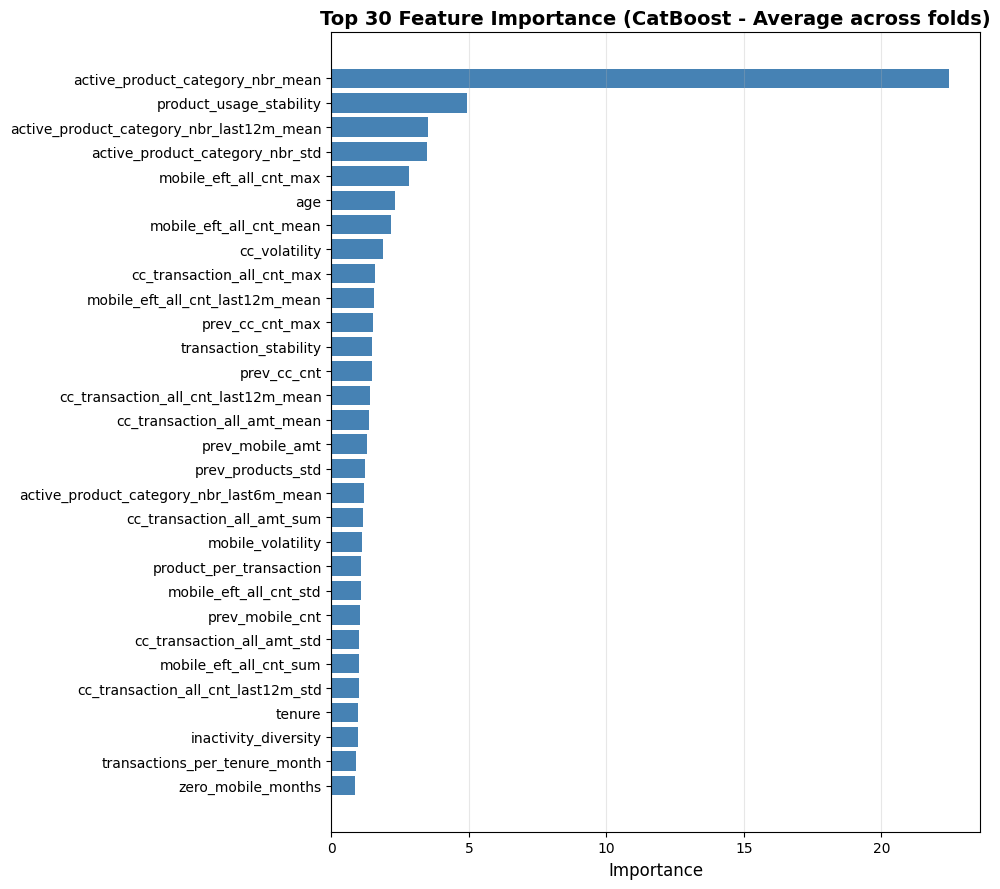

Feature importance saved to 'catboost_feature_importance.csv'

STEP 5: TEST PREDICTIONS AND SUBMISSION

Making test predictions (5 models)...
Averaged predictions from 5 models.

Submission file created: submission_catboost.csv
  Shape: (43006, 2)
  Prediction statistics:
    Min:    0.003066
    Max:    0.775310
    Mean:   0.357688
    Median: 0.366433

STEP 6: SAVE MODELS
5 models saved: models/catboost_churn_fold*.cbm

PROJECT COMPLETION STATUS

COMPLETED STEPS:
  1. Data Loading and Preparation
     - Train: 133287 customers
     - Test: 43006 customers

  2. Feature Engineering
     - Total 141 features created

  3. CatBoost Model Training
     - 5-Fold Cross-Validation complete
     - OOF Custom Metric (Example): 1.186404

  4. Test Predictions
     - Predictions made for 43006 customers

  5. Files Created
     - submission_catboost.csv
     - catboost_feature_importance.csv
     - models/catboost_churn_fold*.cbm (5 models)

SUBMISSION STATISTICS:
  - Min Prediction: 0.003066


In [18]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import your custom metric functions
from custom_metrics import ing_hubs_datathon_metric, recall_at_k, lift_at_k, convert_auc_to_gini

class CatBoostChurnTrainer:
    """
    CatBoost model training with custom metrics for churn.
    """
    def __init__(self, n_folds=5, random_state=42):
        self.n_folds = n_folds
        self.random_state = random_state
        self.models = []
        self.oof_predictions = None
        self.cv_scores = []
        self.feature_importance = None
        
    def train(self, X_train, y_train, categorical_features=None, params=None):
        """
        Train a CatBoost model using cross-validation.
        
        Args:
            X_train: Training features
            y_train: Training targets
            categorical_features: List of categorical features
            params: CatBoost parameters (optional)
        """
        print("="*80)
        print("CATBOOST TRAINING STARTED")
        print("="*80)
        
        # Default parameters
        if params is None:
            params = {
                'iterations': 2000,
                'learning_rate': 0.03,
                'depth': 8,
                'l2_leaf_reg': 3,
                'min_data_in_leaf': 20,
                'random_strength': 0.5,
                'bagging_temperature': 0.2,
                'od_type': 'Iter',
                'od_wait': 50,
                'random_seed': self.random_state,
                'verbose': 100,
                'task_type': 'CPU',  # Change to 'GPU' if available
                'loss_function': 'Logloss',
                'eval_metric': 'AUC'
            }
        
        # Auto-detect categorical features
        if categorical_features is None:
            categorical_features = self._detect_categorical_features(X_train)
        
        print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
        
        # Create array for Out-of-fold predictions
        self.oof_predictions = np.zeros(len(X_train))
        
        # Stratified K-Fold
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, 
                              random_state=self.random_state)
        
        # To collect feature importances
        feature_importance_list = []
        
        print(f"\nStarting {self.n_folds}-Fold Cross-Validation...\n")
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
            print(f"{'='*80}")
            print(f"FOLD {fold}/{self.n_folds}")
            print(f"{'='*80}")
            
            # Train and validation split
            X_tr = X_train.iloc[train_idx]
            X_val = X_train.iloc[val_idx]
            y_tr = y_train.iloc[train_idx]
            y_val = y_train.iloc[val_idx]
            
            print(f"Train: {len(X_tr)} samples, Val: {len(X_val)} samples")
            print(f"Train churn rate: {y_tr.mean():.2%}, Val churn rate: {y_val.mean():.2%}")
            
            # Create CatBoost Pool
            train_pool = Pool(
                data=X_tr,
                label=y_tr,
                cat_features=categorical_features
            )
            
            val_pool = Pool(
                data=X_val,
                label=y_val,
                cat_features=categorical_features
            )
            
            # Create and train model
            model = CatBoostClassifier(**params)
            
            model.fit(
                train_pool,
                eval_set=val_pool,
                use_best_model=True,
                plot=False
            )
            
            # Validation predictions
            val_pred = model.predict_proba(X_val)[:, 1]
            self.oof_predictions[val_idx] = val_pred
            
            # Metric calculations
            auc = roc_auc_score(y_val, val_pred)
            gini = convert_auc_to_gini(auc)
            recall_10 = recall_at_k(y_val, val_pred, k=0.1)
            lift_10 = lift_at_k(y_val, val_pred, k=0.1)
            custom_score = ing_hubs_datathon_metric(y_val, val_pred)
            
            print(f"\n{'='*60}")
            print(f"FOLD {fold} RESULTS:")
            print(f"{'='*60}")
            print(f"  ROC-AUC:        {auc:.6f}")
            print(f"  Gini:           {gini:.6f}")
            print(f"  Recall@10%:     {recall_10:.6f}")
            print(f"  Lift@10%:       {lift_10:.6f}")
            print(f"  Custom Metric:  {custom_score:.6f}")
            print(f"{'='*60}\n")
            
            # Save scores
            fold_scores = {
                'fold': fold,
                'auc': auc,
                'gini': gini,
                'recall_at_10': recall_10,
                'lift_at_10': lift_10,
                'custom_metric': custom_score
            }
            self.cv_scores.append(fold_scores)
            
            # Save feature importances
            fold_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': model.feature_importances_,
                'fold': fold
            })
            feature_importance_list.append(fold_importance)
            
            # Save the model
            self.models.append(model)
        
        # Calculate average feature importance
        self.feature_importance = pd.concat(feature_importance_list).groupby('feature')['importance'].mean().reset_index()
        self.feature_importance = self.feature_importance.sort_values('importance', ascending=False)
        
        # Overall OOF scores
        self._print_overall_scores(y_train)
        
        return self
    
    def _detect_categorical_features(self, X):
        """Auto-detect categorical features."""
        categorical_features = []
        for col in X.columns:
            if '_encoded' in col or X[col].dtype == 'object' or X[col].nunique() < 20:
                categorical_features.append(col)
        return categorical_features
    
    def _print_overall_scores(self, y_true):
        """Print overall OOF scores."""
        print("\n" + "="*80)
        print("OVERALL OUT-OF-FOLD RESULTS")
        print("="*80)
        
        # OOF metrics
        oof_auc = roc_auc_score(y_true, self.oof_predictions)
        oof_gini = convert_auc_to_gini(oof_auc)
        oof_recall_10 = recall_at_k(y_true, self.oof_predictions, k=0.1)
        oof_lift_10 = lift_at_k(y_true, self.oof_predictions, k=0.1)
        oof_custom = ing_hubs_datathon_metric(y_true, self.oof_predictions)
        
        print(f"\nOOF (Out-of-Fold) Scores:")
        print(f"  ROC-AUC:        {oof_auc:.6f}")
        print(f"  Gini:           {oof_gini:.6f}")
        print(f"  Recall@10%:     {oof_recall_10:.6f}")
        print(f"  Lift@10%:       {oof_lift_10:.6f}")
        print(f"  Custom Metric:  {oof_custom:.6f}")
        
        # Fold-wise statistics
        cv_df = pd.DataFrame(self.cv_scores)
        print(f"\nFold-wise Statistics:")
        print(cv_df.to_string(index=False))
        
        print(f"\nAverage ± Std:")
        for metric in ['auc', 'gini', 'recall_at_10', 'lift_at_10', 'custom_metric']:
            mean_val = cv_df[metric].mean()
            std_val = cv_df[metric].std()
            print(f"  {metric:20s}: {mean_val:.6f} ± {std_val:.6f}")
        
        print("="*80)
    
    def predict(self, X_test, average=True):
        """
        Predict on test data.
        
        Args:
            X_test: Test features
            average: True to average predictions from all fold models
        
        Returns:
            Prediction probabilities
        """
        if not self.models:
            raise ValueError("Model not trained! Call train() first.")
        
        print(f"\nMaking test predictions ({len(self.models)} models)...")
        
        predictions = np.zeros((len(X_test), len(self.models)))
        
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict_proba(X_test)[:, 1]
        
        if average:
            final_predictions = predictions.mean(axis=1)
            print(f"Averaged predictions from {len(self.models)} models.")
        else:
            final_predictions = predictions
            print(f"Returned predictions from each fold separately.")
        
        return final_predictions
    
    def plot_feature_importance(self, top_n=30):
        """Plot feature importance."""
        if self.feature_importance is None:
            raise ValueError("Model not trained!")
        
        plt.figure(figsize=(10, max(8, top_n * 0.3)))
        
        top_features = self.feature_importance.head(top_n)
        
        plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'Top {top_n} Feature Importance (CatBoost - Average across folds)', 
                  fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def save_models(self, path_prefix='catboost_model'):
        """Save all fold models."""
        for i, model in enumerate(self.models, 1):
            model.save_model(f'{path_prefix}_fold{i}.cbm')
        print(f"{len(self.models)} models saved: {path_prefix}_fold*.cbm")
    
    def create_submission(self, test_predictions, test_ids, filename='submission.csv'):
        """Create a submission file in the competition format."""
        submission = pd.DataFrame({
            'cust_id': test_ids,
            'churn': test_predictions
        })
        
        submission.to_csv(filename, index=False)
        
        print(f"\nSubmission file created: {filename}")
        print(f"  Shape: {submission.shape}")
        print(f"  Prediction statistics:")
        print(f"    Min:    {test_predictions.min():.6f}")
        print(f"    Max:    {test_predictions.max():.6f}")
        print(f"    Mean:   {test_predictions.mean():.6f}")
        print(f"    Median: {np.median(test_predictions):.6f}")
        
        return submission


"""
FULL CATBOOST CHURN PREDICTION PIPELINE
==========================================
Data loading -> Feature Engineering -> Model Training -> Submission
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


print("\n" + "="*80)
print("STEP 3: CATBOOST MODEL TRAINING")
print("="*80)


# Initialize trainer
trainer = CatBoostChurnTrainer(n_folds=5, random_state=42)

# CatBoost parameters
catboost_params = {
    'iterations': 2000,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 3,
    'min_data_in_leaf': 20,
    'random_strength': 0.5,
    'bagging_temperature': 0.2,
    'border_count': 128,
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': 42,
    'verbose': 100,
    'task_type': 'GPU',  # Change to 'GPU' if available
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'auto_class_weights': 'Balanced'  # For imbalanced data
}

# Identify categorical features (encoded columns from ChurnFeatureEngineer)
categorical_features = [col for col in X_train.columns if '_encoded' in col]

print(f"\nNumber of categorical features: {len(categorical_features)}")

# Train the model
trainer.train(X_train, y_train, categorical_features=categorical_features, params=catboost_params)

# ============================================================================
# STEP 4: FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("STEP 4: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Plot top 30 features
trainer.plot_feature_importance(top_n=30)

# Save feature importance
trainer.feature_importance.to_csv('catboost_feature_importance.csv', index=False)
print("Feature importance saved to 'catboost_feature_importance.csv'")

# ============================================================================
# STEP 5: TEST PREDICTIONS AND SUBMISSION
# ============================================================================
print("\n" + "="*80)
print("STEP 5: TEST PREDICTIONS AND SUBMISSION")
print("="*80)

# Test predictions (average of 5 fold models)
test_predictions = trainer.predict(X_test, average=True)

# Create submission file
submission = trainer.create_submission(
    test_predictions, 
    ref_test['cust_id'], 
    filename='submission_catboost.csv'
)

# ============================================================================
# STEP 6: SAVE MODELS (OPTIONAL)
# ============================================================================
print("\n" + "="*80)
print("STEP 6: SAVE MODELS")
print("="*80)

trainer.save_models('models/catboost_churn')

# ============================================================================
# STEP 7: FINAL CHECKS AND SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PROJECT COMPLETION STATUS")
print("="*80)

# Example: Accessing a score from the first fold
try:
    example_metric = trainer.cv_scores[0]['custom_metric']
except (IndexError, KeyError):
    example_metric = 0.0

print(f"""
COMPLETED STEPS:
  1. Data Loading and Preparation
     - Train: {len(ref_train)} customers
     - Test: {len(ref_test)} customers
  
  2. Feature Engineering
     - Total {X_train.shape[1]} features created
  
  3. CatBoost Model Training
     - 5-Fold Cross-Validation complete
     - OOF Custom Metric (Example): {example_metric:.6f}
  
  4. Test Predictions
     - Predictions made for {len(test_predictions)} customers
  
  5. Files Created
     - submission_catboost.csv
     - catboost_feature_importance.csv
     - models/catboost_churn_fold*.cbm (5 models)

SUBMISSION STATISTICS:
  - Min Prediction: {test_predictions.min():.6f}
  - Max Prediction: {test_predictions.max():.6f}
  - Mean:           {test_predictions.mean():.6f}
  - Median:         {np.median(test_predictions):.6f}
""")